In [83]:
# Dicoding Course "Belajar Pengembangan Machine Learning" 1st Project: NLP

# News Category Classifier

# Hanif Rachmadani on 14/07/2021.

# Dataset used : https://www.kaggle.com/hgultekin/bbcnewsarchive

In [1]:
# TF & Data-prepping Libraries Import

from google.colab import files

import tensorflow as tf
import pandas as pd

from sklearn.model_selection import train_test_split

In [2]:
# Dataset Download

files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

!kaggle datasets download -d hgultekin/bbcnewsarchive

!mkdir bbcnewsarchive
!unzip bbcnewsarchive.zip -d bbcnewsarchive
!ls bbcnewsarchive

Saving kaggle.json to kaggle (5).json
kaggle.json
bbcnewsarchive.zip: Skipping, found more recently modified local copy (use --force to force download)
mkdir: cannot create directory ‘bbcnewsarchive’: File exists
Archive:  bbcnewsarchive.zip
replace bbcnewsarchive/bbc-news-data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: bbcnewsarchive/bbc-news-data.csv  
bbc-news-data.csv


In [3]:
# Initial Dataframe Loading

df_initial = pd.read_csv('bbcnewsarchive/bbc-news-data.csv', sep='\t')

df_initial.head()

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


In [20]:
# Dataframe Prepping

emotion = pd.get_dummies(df_initial.category)
df_new = pd.concat([df_initial,emotion],axis=1)

df_new['title'] = df_new['title'] + df_new['content']

df_new.rename(columns={'title':'fulltext'},inplace='true')
df_new.drop(columns=['filename','content','category'], inplace=True)

df_new.head()

,fulltext,business,entertainment,politics,sport,tech
0,Ad sales boost Time Warner profit Quarterly pr...,1,0,0,0,0
1,Dollar gains on Greenspan speech The dollar ha...,1,0,0,0,0
2,Yukos unit buyer faces loan claim The owners o...,1,0,0,0,0
3,High fuel prices hit BA's profits British Airw...,1,0,0,0,0
4,Pernod takeover talk lifts Domecq Shares in UK...,1,0,0,0,0


In [38]:
# Lemmatizer & Stopwords Libraries Import

import nltk
import numpy as np
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [40]:
# Stop Words Filter

def filter_stop_words(train_sentences, stop_words):
    for i, sentence in enumerate(train_sentences):
        new_sent = [word for word in sentence if word not in stop_words]
        train_sentences[i] = ' '.join(new_sent)
    return train_sentences

In [39]:
# Stop Words Filtering & Word Lemmatizing

stop_words = stopwords.words('english')

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w,pos='v') for w in text] 

text = df_new['fulltext'].apply(nltk.word_tokenize).apply(lemmatize_text)
text = filter_stop_words(text, stop_words)

In [41]:
# Train Test Split

text = text.values
label = df_new[['business','entertainment','politics','sport','tech']].values

text_train, text_val, label_train, label_val = train_test_split(text, label, test_size=0.2)   # Validation Data 20% Total

print(text_train)
print(label_train)

["Ferguson rue failure cut gap Boss Sir Alex Ferguson leave rue Manchester United 's failure close gap Chelsea , Everton Arsenal side 's 1-1 draw Fulham . Premiership leaders Chelsea Gunners endure 2-2 stalemate Sunday , give United chance make grind league . But Ferguson say : `` I think make bad rival drop point weekend . `` It great opportunity - n't deliver . '' United go ahead Alan Smith 33rd minute Bouba Diop 's superb 25-yard strike cancel visitors ' lead 87th minute . Ferguson describe result `` absolute giveaway '' United earlier miss host opportunities finish encounter . He say : `` It good performance - football fantastic - n't finish . `` In fairness , 's fantastic strike Fulham player . '' The result leave Ferguson 's side fourth league 31 point - four point behind Arsenal five back Chelsea ."
 "Dollar drop reserve concern The US dollar drop major currencies concern central bank may cut amount dollars hold foreign reserve . Comments South Korea 's central bank end last wee

In [42]:
# Data Tokenizing, Sequencing, & Padding

max_words = 1000      # Max Tokenized Words
sent_length = 300     # Max Sentence Length
trunc_type = "post"   # Truncation Type

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=max_words, oov_token='oov', filters='"#$%&()*+,-./:;<=>@[\\]^_`{|}~\t\n1234567890') 

tokenizer.fit_on_texts(text_train) 
tokenizer.fit_on_texts(text_val)

train_seq = tokenizer.texts_to_sequences(text_train)
val_seq = tokenizer.texts_to_sequences(text_val )
 
padded_train = pad_sequences(train_seq, truncating=trunc_type, maxlen=sent_length) 
padded_val = pad_sequences(val_seq, truncating=trunc_type, maxlen=sent_length)

In [43]:
# Model Design

# 1 Embedding Layer, 1 LSTM Layer, 2 Hidden Layer, 1 Output Layer

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=max_words, output_dim=64, input_length=sent_length),  
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')                                
])

# Model Compilation

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 300, 64)           64000     
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 5)                

In [32]:
# Callback Function Declaration

class modelCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9 and logs.get('val_accuracy')>0.9):  
      print("Accuracy Target of >90% on Both Datasets Reached, Stopping Training...")
      self.model.stop_training = True


In [36]:
# Model Training

history = model.fit(
            padded_train,
            label_train,
            batch_size=32,                            # 32 Data per Batch Loading
            steps_per_epoch=50,                       # 50 Batches Used per Epoch for Training
            epochs=50,                                # 50 Maximum Epoch (Arbitratry)
            validation_data=(padded_val,label_val),     
            validation_steps=10,                      # 10 Batches Used per Epoch for Validation
            callbacks=[modelCallback()],              # Callback
            verbose='auto')


Epoch 1/50
50/50 [==============================] - 18s 326ms/step - loss: 1.6258 - accuracy: 0.2375 - val_loss: 1.6045 - val_accuracy: 0.2625
Epoch 2/50
50/50 [==============================] - 16s 317ms/step - loss: 1.5776 - accuracy: 0.3111 - val_loss: 1.5241 - val_accuracy: 0.3406
Epoch 3/50
50/50 [==============================] - 16s 314ms/step - loss: 1.2559 - accuracy: 0.4219 - val_loss: 1.0502 - val_accuracy: 0.4406
Epoch 4/50
50/50 [==============================] - 16s 315ms/step - loss: 1.0550 - accuracy: 0.4830 - val_loss: 0.9497 - val_accuracy: 0.5219
Epoch 5/50
50/50 [==============================] - 16s 317ms/step - loss: 0.9868 - accuracy: 0.5491 - val_loss: 0.8544 - val_accuracy: 0.6156
Epoch 6/50
50/50 [==============================] - 16s 319ms/step - loss: 0.8522 - accuracy: 0.6266 - val_loss: 1.0206 - val_accuracy: 0.5875
Epoch 7/50
50/50 [==============================] - 16s 319ms/step - loss: 0.9591 - accuracy: 0.5472 - val_loss: 0.8485 - val_accuracy: 0.6281

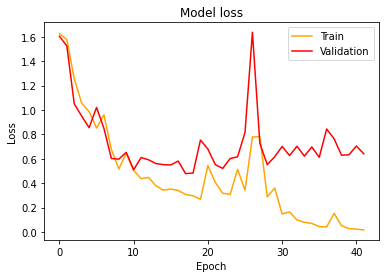

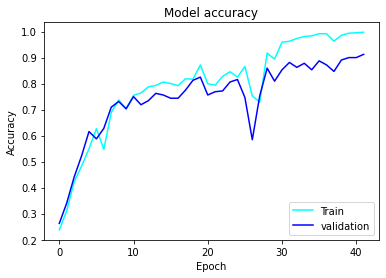

In [37]:
# Pyplot Import

import matplotlib.pyplot as plt

# Loss & Accuracy Graph

plt.plot(history.history['loss'], color="orange")
plt.plot(history.history['val_loss'], color="red")
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'], color="cyan")
plt.plot(history.history['val_accuracy'], color="blue")
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','validation'], loc='lower right')
plt.show()